### Setup

In [3]:
import os

if os.getenv("COLAB_RELEASE_TAG"):
   !git clone https://github.com/muhd-umer/aecc.git
   %cd aecc
   !pip install einops python-box timm torchinfo lightning rich wandb rawpy umap-learn
   !wget -P ./weights/ \
        https://github.com/muhd-umer/aecc/releases/download/v0.0.1/dae_vit_small_imagenette.ckpt
   !wget -P ./data/ \
        https://github.com/muhd-umer/aecc/releases/download/v0.0.1/imagenette320p.zip
   %cd data/
   !unzip -q imagenette320p.zip
   %cd ..
   !python setup.py build_ext --inplace
else:
   print("Assuming weights & data are set up correctly.")

Assuming weights & data are set up correctly.


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchinfo
import torchvision
from torch import nn

from config import *
from data import *
from models import *
from utils import *
import pandas as pd

from umap import UMAP

os.makedirs("report/figs/", exist_ok=True)
plt.rcParams["font.family"] = "STIXGeneral"

/home/zniu9834/miniconda3/envs/aecc/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [12]:
cfg = get_defaults()
cfg = get_cfg(
    "dae_vit_tiny", "cifar10", "config/model_cfg.yaml", "config/data_cfg.yaml", cfg
)

cfg.batch_size = 4
# cfg.patch_size = 16
cfg.pretrained = True

yaml_cfg = cfg.to_yaml()

print(colored(f"Config:", "green", attrs=["bold"]))
print(colored(yaml_cfg))

Config:
batch_size: 4
data_dir: /home/zniu9834/ViT-Semantic-Communication/data
dataset: cifar10
decoder_head: 6
decoder_layer: 8
device: cuda
emb_dim: 96
encoder_head: 3
encoder_layer: 12
img_size: 32
in_channels: 3
log_dir: /home/zniu9834/ViT-Semantic-Communication/logs
lr: 0.0005
model_dir: /home/zniu9834/ViT-Semantic-Communication/weights
model_name: dae_vit_tiny
momentum: 0.9
noise_factor: 0.25
normalize: default
num_epochs: 100
num_workers: 4
patch_size: 4
pin_memory: true
pretrained: true
root_dir: /home/zniu9834/ViT-Semantic-Communication
seed: 42
val_freq: 10
val_size: 0.1
weight_decay: 0.005



### Visualizing Data

In [21]:
def fgsm_attack(model, images, epsilon):
    """
    FGSM attack for autoencoder-style models like DAEViT.

    Args:
        model: a reconstruction model (e.g., autoencoder)
        images: input tensor (B, C, H, W)
        epsilon: attack strength

    Returns:
        Adversarial images
    """
    images = images.clone().detach().to(cfg.device)
    images.requires_grad = True

    # Forward through autoencoder
    reconstructed = model(images)

    # Use reconstruction loss (MSE)
    loss = F.mse_loss(reconstructed, images)
    model.zero_grad()
    loss.backward()

    # Perturb in direction of gradient
    perturbed = images + epsilon * images.grad.sign()
    perturbed = torch.clamp(perturbed, 0, 1)

    return perturbed

In [22]:
train_dataloader, val_dataloader, test_dataloader, steps_per_epoch = load_dataset(cfg)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.100000024..0.100000024].


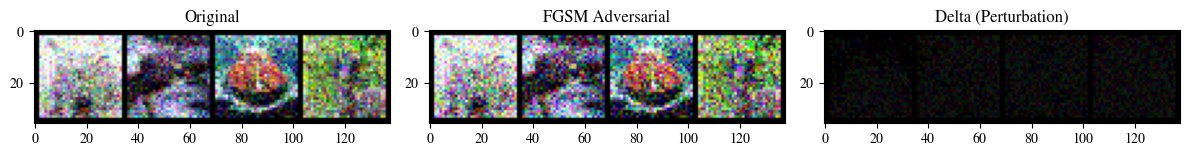

In [24]:
images, _ = next(iter(train_dataloader))
images = images.to(cfg.device)

model.eval()
adv_images = fgsm_attack(model, images, epsilon=0.1)

# 对比展示
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(np.transpose(torchvision.utils.make_grid(images[:8].cpu(), nrow=4), (1, 2, 0)))
plt.title("Original")

plt.subplot(1, 3, 2)
plt.imshow(np.transpose(torchvision.utils.make_grid(adv_images[:8].cpu(), nrow=4), (1, 2, 0)))
plt.title("FGSM Adversarial")

plt.subplot(1, 3, 3)
plt.imshow(np.transpose(torchvision.utils.make_grid((adv_images - images)[:8].cpu(), nrow=4), (1, 2, 0)))
plt.title("Delta (Perturbation)")
plt.tight_layout()
plt.savefig("report/figs/fgsm_daevit_visual.pdf", dpi=300)
plt.show()


In [14]:
model = DAEViT(
    in_channels=cfg.in_channels,
    img_size=cfg.img_size,
    patch_size=cfg.patch_size,
    emb_dim=cfg.emb_dim,
    encoder_layer=cfg.encoder_layer,
    encoder_head=cfg.encoder_head,
    decoder_layer=cfg.decoder_layer,
    decoder_head=cfg.decoder_head,
    gate=nn.Sigmoid,
)
model = model.to(cfg.device)

# 加载预训练权重（如果启用）
if cfg.pretrained:
    state_dict = torch.load(
        f"weights/{cfg.model_name}_{cfg.dataset}.ckpt", map_location=cfg.device
    )["state_dict"]
    state_dict = {k.replace("model.", ""): v for k, v in state_dict.items()}
    model.load_state_dict(state_dict)

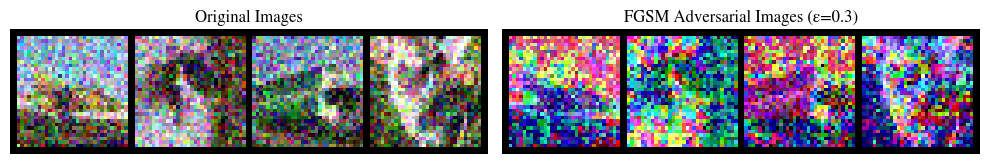

In [ ]:
# 加载一批样本
images, labels = next(iter(train_dataloader))
images, labels = images.to(cfg.device), labels.to(cfg.device)

# 使用原始模型执行 FGSM 攻击
model.eval()  # VERY IMPORTANT for inference mode
adv_images = fgsm_attack(model, images, labels, epsilon=0.1)

# 可视化对比 原始图像 vs. 对抗图像
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(
    np.transpose(torchvision.utils.make_grid(images[:8].cpu(), padding=2, nrow=4), (1, 2, 0))
)
plt.axis("off")
plt.title("Original Images")

plt.subplot(1, 2, 2)
plt.imshow(
    np.transpose(torchvision.utils.make_grid(adv_images[:8].cpu(), padding=2, nrow=4), (1, 2, 0))
)
plt.axis("off")
plt.title("FGSM Adversarial Images (ε=0.3)")

plt.tight_layout()
plt.savefig("report/figs/fgsm_comparison.pdf", bbox_inches="tight", dpi=300)
plt.show()


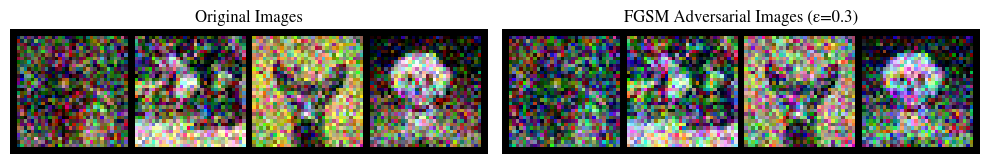

In [ ]:
# 加载一批样本
images, labels = next(iter(train_dataloader))
images, labels = images.to(cfg.device), labels.to(cfg.device)

# 使用原始模型执行 FGSM 攻击
model.eval()  # VERY IMPORTANT for inference mode
adv_images = fgsm_attack(model, images, labels, epsilon=0.1)

# 可视化对比 原始图像 vs. 对抗图像
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(
    np.transpose(torchvision.utils.make_grid(images[:8].cpu(), padding=2, nrow=4), (1, 2, 0))
)
plt.axis("off")
plt.title("Original Images")

plt.subplot(1, 2, 2)
plt.imshow(
    np.transpose(torchvision.utils.make_grid(adv_images[:8].cpu(), padding=2, nrow=4), (1, 2, 0))
)
plt.axis("off")
plt.title("FGSM Adversarial Images (ε=0.1)")

plt.tight_layout()
plt.savefig("report/figs/fgsm_comparison.pdf", bbox_inches="tight", dpi=300)
plt.show()


In [17]:
import sys

sys.path.append("..")

import os
import numpy as np

import torch
from torch import nn
import torch.nn.functional as F

from utils_fgsm import tensor2cuda


def project(x, original_x, epsilon, _type='linf'):
    if _type == 'linf':
        max_x = original_x + epsilon
        min_x = original_x - epsilon
        x = torch.max(torch.min(x, max_x), min_x)

    elif _type == 'l2':
        dist = (x - original_x)
        dist = dist.view(x.shape[0], -1)
        dist_norm = torch.norm(dist, dim=1, keepdim=True)
        mask = (dist_norm > epsilon).unsqueeze(2).unsqueeze(3)
        # dist = F.normalize(dist, p=2, dim=1)
        dist = dist / dist_norm
        dist *= epsilon
        dist = dist.view(x.shape)
        x = (original_x + dist) * mask.float() + x * (1 - mask.float())
    else:
        raise NotImplementedError
    return x


class FastGradientSignUntargeted():
    """
        Fast gradient sign untargeted adversarial attack, minimizes the initial class activation
        with iterative grad sign updates
    """

    def __init__(self, model, epsilon, alpha, min_val, max_val, max_iters, _type='linf'):
        self.model = model
        # self.model.eval()

        # Maximum perturbation
        self.epsilon = epsilon
        # Movement multiplier per iteration
        self.alpha = alpha
        # Minimum value of the pixels
        self.min_val = min_val
        # Maximum value of the pixels
        self.max_val = max_val
        # Maximum numbers of iteration to generated adversaries
        self.max_iters = max_iters
        # The perturbation of epsilon
        self._type = _type


    # def perturb(self, original_images, labels, bm_pos, reduction4loss='mean', random_start=False, beta=2):
    #     # original_images: values are within self.min_val and self.max_val
    #     # The adversaries created from random close points to the original data
    #     if random_start:
    #         rand_perturb = torch.FloatTensor(original_images.shape).uniform_(
    #             -self.epsilon, self.epsilon)
    #         rand_perturb = tensor2cuda(rand_perturb)
    #         x = original_images + rand_perturb
    #         x.clamp_(self.min_val, self.max_val)
    #     else:
    #         x = original_images.clone()
    #     x.requires_grad = True
    #     self.model.eval()

    #     with torch.enable_grad():
    #         for _iter in range(self.max_iters):
    #             outputs = self.model(x, bm_pos, labels, _eval=True)
    #             outputs_x= outputs['out_x']
    #             loss = F.cross_entropy(outputs_x, labels, reduction=reduction4loss)
    #             fim_loss = 0.
    #             if 'out_c' in outputs.keys():
    #                 for extra_output in outputs['out_c']:
    #                     fim_loss += F.cross_entropy(extra_output, labels, reduction=reduction4loss)
    #                 if len(outputs['out_c']) > 0:
    #                     fim_loss /= len(outputs['out_c'])
                        
    #                 loss += beta * fim_loss
    #             if 'vq_loss' in outputs.keys():
    #                 loss += outputs['vq_loss']

    #             if reduction4loss == 'none':
    #                 grad_outputs = tensor2cuda(torch.ones(loss.shape))

    #             else:
    #                 grad_outputs = None

    #             grads = torch.autograd.grad(loss, x, grad_outputs=grad_outputs,
    #                                         only_inputs=True)[0]
    #             x.data += self.alpha * torch.sign(grads.data)
    #             # the adversaries' pixel value should within max_x and min_x due
    #             # to the l_infinity / l2 restriction
    #             x = project(x, original_images, self.epsilon, self._type)
    #             x.clamp_(self.min_val, self.max_val)
    #     self.model.train()
    #     return x


    def perturb(self, original_images, labels=None, bm_pos=None, reduction4loss='mean', random_start=False, beta=2):
        if random_start:
            rand_perturb = torch.FloatTensor(original_images.shape).uniform_(-self.epsilon, self.epsilon)
            rand_perturb = tensor2cuda(rand_perturb)
            x = original_images + rand_perturb
            x.clamp_(self.min_val, self.max_val)
        else:
            x = original_images.clone()
        x.requires_grad = True
        self.model.eval()

        with torch.enable_grad():
            for _iter in range(self.max_iters):
                outputs = self.model(x)  # DeepJSCC的forward方法
                loss = F.mse_loss(outputs, original_images, reduction=reduction4loss)  # 使用MSE损失
                grads = torch.autograd.grad(loss, x, only_inputs=True)[0]
                x.data += self.alpha * torch.sign(grads.data)
                x = project(x, original_images, self.epsilon, self._type)
                x.clamp_(self.min_val, self.max_val)
        self.model.train()
        return x

def norm_psr(v, Rx, psr):
    x_square = torch.mul(Rx, Rx)
    power1 = torch.mean(x_square)
    x_square = torch.mul(v, v)
    power2 = torch.mean(x_square)
    psr = 10 ** (-psr / 10)
    v = v * (power1 * psr / power2).sqrt()
    return v


def FGSM_symbol_attack(pert, model, images, labels, mask_pos, psr):
    x = images.clone()
    reduction4loss = 'mean'
    alpha = 0.5
    x.requires_grad = True
    model.eval()
    with torch.enable_grad():
        for _iter in range(5):
            outputs,_, Rxsig = model(x, mask_pos, pert, psr)
            # outputs, class_wise_output = self.model(x, _eval=True)
            loss = F.cross_entropy(outputs, labels, reduction=reduction4loss)
            if reduction4loss == 'none':
                grad_outputs = tensor2cuda(torch.ones(loss.shape))
            else:
                grad_outputs = None
            grads = torch.autograd.grad(loss, Rxsig, grad_outputs=grad_outputs,
                                        only_inputs=True)[0]
            pert += alpha * torch.sign(grads.data)
            pert = norm_psr(pert, Rxsig, psr)
        return pert




def FGSM_attack_codebook(pert, model, images, labels, mask_pos, psr):
    x = images.clone()
    reduction4loss = 'mean'
    x.requires_grad = True
    model.eval()
    wmbweight = model.vq_layer.embedding.weight
    with torch.enable_grad():
        for _iter in range(1):
            outputs,class_wise_output,vq_loss,_, Rx_index = model(x, mask_pos, labels, pert, attackmimo = False, _eval=True)
            # outputs, class_wise_output = self.model(x, _eval=True)

            loss = F.cross_entropy(outputs, labels, reduction=reduction4loss)
            #loss+= vq_loss
            channel_reg_loss = 0.
            for extra_output in class_wise_output:
                channel_reg_loss += F.cross_entropy(extra_output, labels, reduction=reduction4loss)
                # channel_reg_loss += F.cross_entropy(extra_output, reduction=reduction4loss)
            if len(class_wise_output) > 0:
                channel_reg_loss /= len(class_wise_output)
            #print(vq_loss)
           # loss += 1 * channel_reg_loss
            if reduction4loss == 'none':
                grad_outputs = tensor2cuda(torch.ones(loss.shape))

            else:
                grad_outputs = None
            grads = torch.autograd.grad(loss, Rx_index, grad_outputs=grad_outputs,
                                        only_inputs=True)[0]
            index = torch.zeros((196,1), dtype = torch.int64)
            for i in range(Rx_index.shape[1]):
                temp = Rx_index[0,i,:] - wmbweight
                find_index = torch.mm(temp, grads.data[0, i].unsqueeze(0).t())/(torch.norm(temp, dim=1, keepdim=True)*torch.norm(grads.data[0, i]))
                find_index = torch.max(find_index, dim=0)[1]
                index[i,0] = find_index
            pert = index
        return pert        


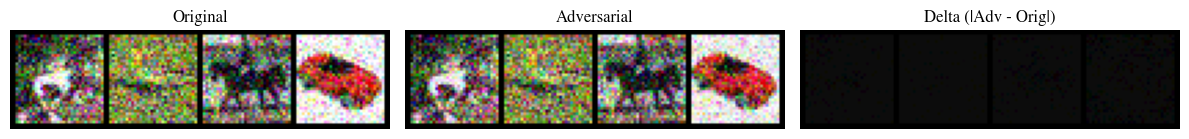

In [20]:
adv_model = FastGradientSignUntargeted(
    model=model,
    epsilon=0.1,
    alpha=0.05,
    min_val=0.0,
    max_val=1.0,
    max_iters=1,
    _type='linf'
)

images, labels = next(iter(train_dataloader))
images, labels = images.to(cfg.device), labels.to(cfg.device)

# 对抗样本生成
adv_images = adv_model.perturb(images, labels)

# 显示对抗效果
import torchvision
import matplotlib.pyplot as plt
import numpy as np

def show_images(images, title, subplot_idx):
    plt.subplot(1, 3, subplot_idx)
    grid = torchvision.utils.make_grid(images[:8], nrow=4, padding=2)
    npimg = grid.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis("off")
    plt.title(title)

plt.figure(figsize=(12, 4))
show_images(images, "Original", 1)
show_images(adv_images, "Adversarial", 2)
show_images(torch.abs(adv_images - images), "Delta (|Adv - Orig|)", 3)
plt.tight_layout()
plt.savefig("report/figs/fgsm_attack_visual_check.pdf", dpi=300)
plt.show()


### Model & Methodology

In [7]:
# Initialize the autoencoder
model = DAEViT(
    in_channels=cfg.in_channels,
    img_size=cfg.img_size,
    patch_size=cfg.patch_size,
    emb_dim=cfg.emb_dim,
    encoder_layer=cfg.encoder_layer,
    encoder_head=cfg.encoder_head,
    decoder_layer=cfg.decoder_layer,
    decoder_head=cfg.decoder_head,
    gate=nn.Sigmoid,
)

if cfg.pretrained:
    state_dict = torch.load(
        f"weights/{cfg.model_name}_{cfg.dataset}.ckpt", map_location=cfg.device
    )["state_dict"]
    state_dict = {k.replace("model.", ""): v for k, v in state_dict.items()}
    model.load_state_dict(state_dict)

torchinfo.summary(
    model, input_size=(1, cfg.in_channels, cfg.img_size, cfg.img_size), depth=2
)

FileNotFoundError: [Errno 2] No such file or directory: 'weights/dae_vit_base_cifar10.ckpt'

Encoder

In [9]:
# Encoder
encoder = model.encoder

# Encode a batch of images
encoded = encoder(original.to(cfg.device))

print(colored("Input shape:", "green"), original.shape)
print(colored("Encoded shape:", "green"), encoded.shape)

Input shape: torch.Size([4, 3, 128, 128])
Encoded shape: torch.Size([257, 4, 384])


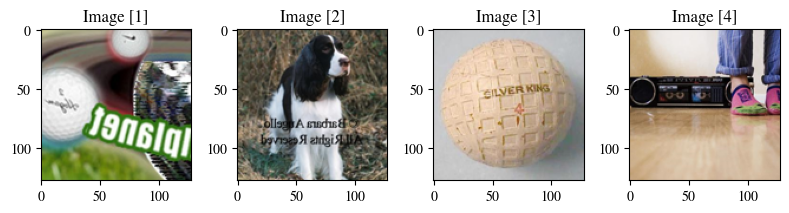

<Figure size 640x480 with 0 Axes>

In [10]:
fig, axs = plt.subplots(1, 4, figsize=(8, 5))

# Loop over the first 4 original images
for i in range(4):
    axs[i].imshow(
        original.permute(0, 2, 3, 1)[i].cpu().detach().numpy(),
    )
    axs[i].set_title(f"Image [{i+1}]")

plt.tight_layout()
plt.savefig("report/figs/batch.pdf", bbox_inches="tight", dpi=300)
plt.show()

plt.tight_layout()
plt.show()

Channel

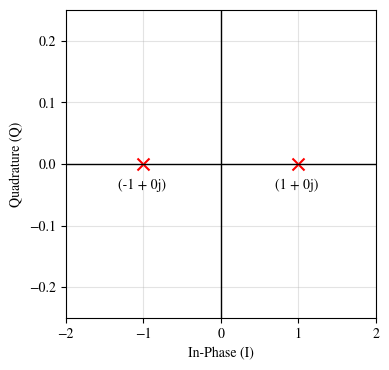

In [11]:
# Instantiate transmission modules
transmitter = BPSKTransmitter()
ieee754_single = IEEE754(precision="single")

# Visualize transmission (through constellations)
bin_rep = ieee754_single.float_to_binary(  # binary representation
    encoded.permute(1, 0, 2).cpu().detach().numpy()
)
bin_arr = transmitter.to_arr(bin_rep)  # str to array
mod_arr = transmitter.modulate(bin_arr)
unique_mod = np.unique(mod_arr)

# Plot constellation
plt.figure(figsize=(4, 4))
plt.scatter(
    unique_mod.real, unique_mod.imag, marker="x", color="red", s=75, label="Noiseless"
)
plt.xlabel("In-Phase (I)")
plt.ylabel("Quadrature (Q)")
plt.xlim(-2, 2)
plt.ylim(-0.25, 0.25)

# Highlight the origin axis
plt.axhline(0, color="black", linewidth=1)
plt.axvline(0, color="black", linewidth=1)

# Add text to points
plt.text(-0.7, -0.04, "(-1 + 0j)", ha="right")
plt.text(0.7, -0.04, "(1 + 0j)", ha="left")

plt.grid(alpha=0.35)
plt.savefig("report/figs/bpsk.pdf", bbox_inches="tight", dpi=300)
plt.show()

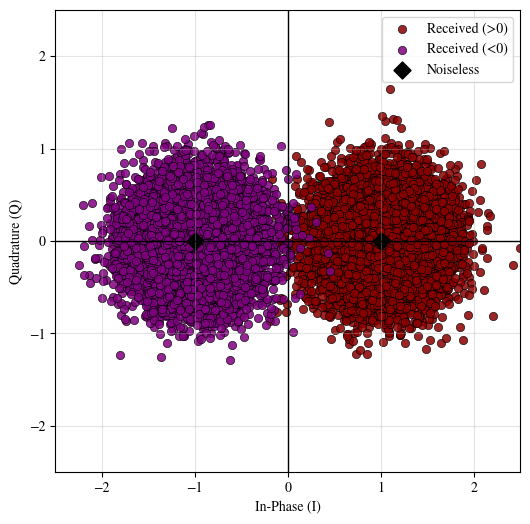

In [12]:
# Add complex noise to each point
def add_noise(x, noise):
    return x + (
        noise
        * (np.random.randn(*x.shape) + 1j * np.random.randn(*x.shape))
        / np.sqrt(2)
    )

fct = 0.5

# Split mod_arr into two arrays based on the condition
mod_arr_gt0 = mod_arr[mod_arr > 0]
mod_arr_lt0 = mod_arr[mod_arr < 0]

# Add noise to both arrays
noisy_mod_arr_gt0 = add_noise(mod_arr_gt0, fct)
noisy_mod_arr_lt0 = add_noise(mod_arr_lt0, fct)

# Plot constellation
plt.figure(figsize=(6, 6))

# Plot the array with values > 0 with color green
plt.scatter(
    noisy_mod_arr_gt0.flatten()[:10000].real,
    noisy_mod_arr_gt0.flatten()[:10000].imag,
    marker="o",
    edgecolor="black",
    linewidth=0.5,
    alpha=0.85,
    color="darkred",
    label="Received (>0)",
)

# Plot the array with values < 0 with color blue
plt.scatter(
    noisy_mod_arr_lt0.flatten()[:10000].real,
    noisy_mod_arr_lt0.flatten()[:10000].imag,
    marker="o",
    edgecolor="black",
    linewidth=0.5,
    alpha=0.85,
    color="purple",
    label="Received (<0)",
)
plt.scatter(
    unique_mod.real, unique_mod.imag, marker="D", color="k", s=75, label="Noiseless"
)
plt.xlabel("In-Phase (I)")
plt.ylabel("Quadrature (Q)")
plt.xlim(-2.5, 2.5)
plt.ylim(-2.5, 2.5)

# Highlight the origin axis
plt.axhline(0, color="black", linewidth=1)
plt.axvline(0, color="black", linewidth=1)

plt.grid(alpha=0.35)
plt.legend()
plt.savefig("report/figs/received_bpsk.pdf", bbox_inches="tight", dpi=300)
plt.show()




In [13]:
#save in csv file
import pandas as pd
#SAVE THE RECIEVED >0 AND rECIVED <0 AND NOISLESS BITS IN A CSV FILE
df = pd.DataFrame(data={"real": noisy_mod_arr_gt0.real, "imag": noisy_mod_arr_gt0.imag})
df.to_csv("report/figs/received_gt0.csv", sep=",", index=False)

In [14]:
# Add rayleigh noise to the encoded images
rayleigh = RayleighChannel(cfg.noise_factor)
encoded_noise = rayleigh(encoded)

print(colored("Encoded shape:", "green"), encoded.shape)
print(colored("Encoded with noise shape:", "green"), encoded_noise.shape)

Encoded shape: torch.Size([257, 4, 384])
Encoded with noise shape: torch.Size([257, 4, 384])


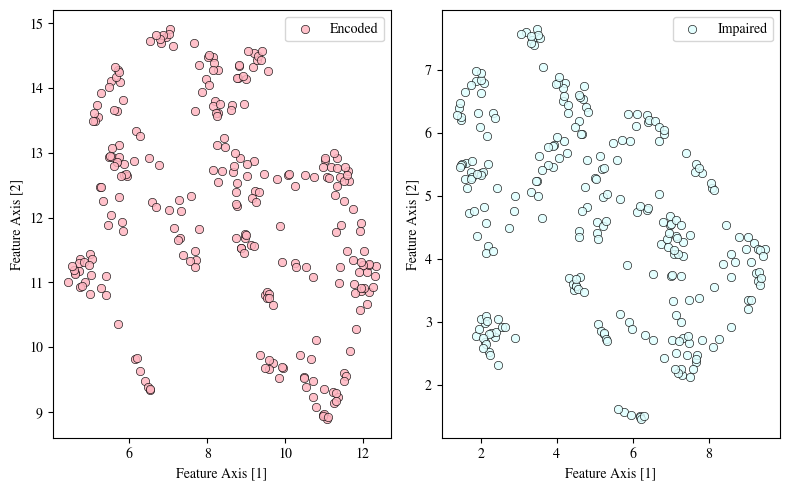

In [15]:
# Flatten the features
flattened_encoded = encoded.reshape(encoded.shape[0], -1).cpu().detach().numpy()
flattened_encoded_noise = (
    encoded_noise.reshape(encoded_noise.shape[0], -1).cpu().detach().numpy()
)

# Apply UMAP
umap = UMAP()
umap_encoded = umap.fit_transform(flattened_encoded)
umap_encoded_noise = umap.fit_transform(flattened_encoded_noise)

# Visualize UMAP encoded features
fig, axs = plt.subplots(1, 2, figsize=(8, 5))

axs[0].scatter(
    umap_encoded[:, 0],
    umap_encoded[:, 1],
    marker="o",
    edgecolor="black",
    linewidth=0.5,
    alpha=0.85,
    color="lightpink",
    label="Encoded",
)
axs[0].set_xlabel("Feature Axis [1]")
axs[0].set_ylabel("Feature Axis [2]")
axs[0].legend()

axs[1].scatter(
    umap_encoded_noise[:, 0],
    umap_encoded_noise[:, 1],
    marker="o",
    edgecolor="black",
    linewidth=0.5,
    alpha=0.85,
    color="lightcyan",
    label="Impaired",
)

axs[1].set_xlabel("Feature Axis [1]")
axs[1].set_ylabel("Feature Axis [2]")
axs[1].legend()

plt.tight_layout()
plt.savefig("report/figs/umap.pdf", bbox_inches="tight", dpi=300)
plt.show()

In [16]:
#Extract the variables into csv file econded and impaired both

df1 = pd.DataFrame(umap_encoded, columns=["Feature Axis [1]", "Feature Axis [2]"])
df1.to_csv("report/figs/umap_encoded.csv", index=False)

df2 = pd.DataFrame(umap_encoded_noise, columns=["Feature Axis [1]", "Feature Axis [2]"])
df2.to_csv("report/figs/umap_encoded_noise.csv", index=False)





Decoder

In [17]:
# Decoder
decoder = model.decoder

# Decode a batch of features
decoded = decoder(encoded_noise.to(cfg.device))

print(colored("Input shape:", "yellow"), encoded_noise.shape)
print(colored("Decoded image:", "yellow"), decoded.shape)

Input shape: torch.Size([257, 4, 384])
Decoded image: torch.Size([4, 3, 128, 128])


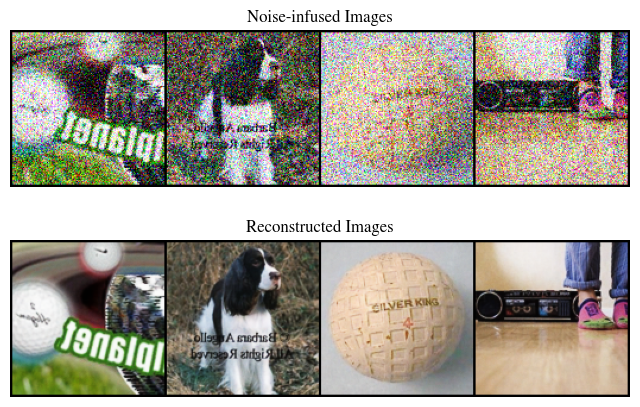

In [18]:
# show images
plt.figure(figsize=(8, 5))
plt.subplot(2, 1, 1)
plt.imshow(
    np.transpose(torchvision.utils.make_grid(noisy[:8], padding=2, nrow=4), (1, 2, 0))
)
plt.axis("off")
plt.title("Noise-infused Images")
plt.subplot(2, 1, 2)
plt.imshow(
    np.transpose(
        torchvision.utils.make_grid(decoded[:8], padding=2, nrow=4).cpu(), (1, 2, 0)
    )
)
plt.title("Reconstructed Images")
plt.axis("off")
plt.savefig("report/figs/comparison.pdf", bbox_inches="tight", dpi=300)
plt.show()

### Results

Train and Validation Loss

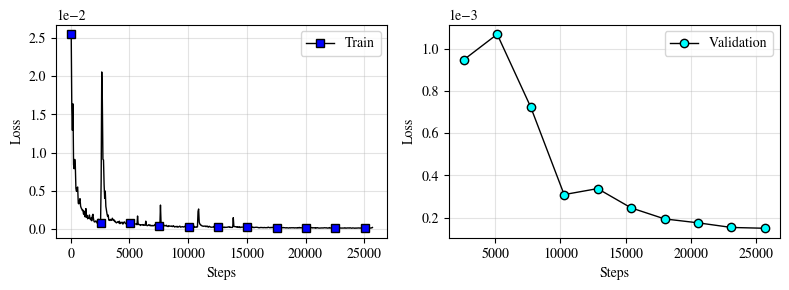

In [19]:
train_df = pd.read_csv("resources/train.csv")
val_df = pd.read_csv("resources/val.csv")

train_x = train_df["Step"]
train_y = train_df["Value"]
val_x = val_df["Step"]
val_y = val_df["Value"]

fig, axs = plt.subplots(1, 2, figsize=(8, 3))  # 1 row, 2 columns

# Plot for training data
axs[0].plot(
    train_x,
    train_y,
    marker="s",
    markerfacecolor="blue",
    markeredgecolor="k",
    color="k",
    linewidth=1,
    label="Train",
    markevery=50,
)
axs[0].set_xlabel("Steps")
axs[0].set_ylabel("Loss")
axs[0].ticklabel_format(
    style="sci", axis="y", scilimits=(0, 0)
)  # Change to scientific notation
axs[0].grid(alpha=0.35)
axs[0].legend()

# Plot for validation data
axs[1].plot(
    val_x,
    val_y,
    marker="o",
    markerfacecolor="cyan",
    markeredgecolor="k",
    color="k",
    linewidth=1,
    label="Validation",
)
axs[1].set_xlabel("Steps")
axs[1].set_ylabel("Loss")
axs[1].ticklabel_format(
    style="sci", axis="y", scilimits=(0, 0)
)  # Change to scientific notation
axs[1].grid(alpha=0.35)
axs[1].legend()

plt.tight_layout()
plt.savefig("report/figs/loss.pdf", bbox_inches="tight", dpi=300)
plt.show()

Structural Similarity Index (SSIM)

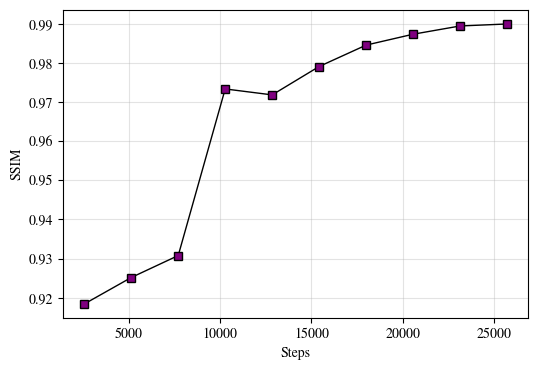

In [20]:
df = pd.read_csv("resources/ssim.csv")
x = df["Step"]
y = df["Value"]

plt.figure(figsize=(6, 4))
plt.plot(
    x,
    y,
    marker="s",
    markerfacecolor="purple",
    markeredgecolor="k",
    color="k",
    linewidth=1,
)
plt.xlabel("Steps")
plt.ylabel("SSIM")
plt.grid(alpha=0.35)
plt.savefig("report/figs/ssim.pdf", bbox_inches="tight", dpi=300)
plt.show()

Peak Signal-to-Noise Ratio (PSNR)

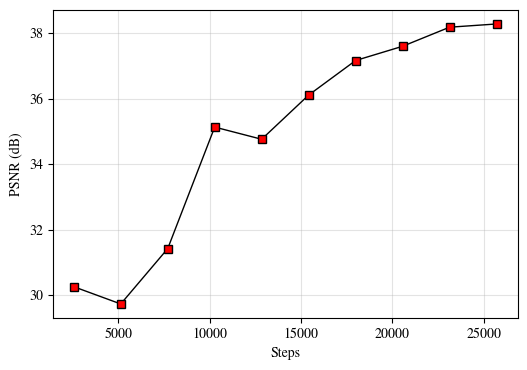

In [21]:
df = pd.read_csv("resources/psnr.csv")
x = df["Step"]
y = df["Value"]

plt.figure(figsize=(6, 4))
plt.plot(
    x,
    y,
    marker="s",
    markerfacecolor="red",
    markeredgecolor="k",
    color="k",
    linewidth=1,
)
plt.xlabel("Steps")
plt.ylabel("PSNR (dB)")
plt.grid(alpha=0.35)
plt.savefig("report/figs/psnr.pdf", bbox_inches="tight", dpi=300)
plt.show()